In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
imagePatches = glob('E:/Deep Learning/Project/archive (2)/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1001_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1051_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1101_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1151_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1201_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1251_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1301_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1351_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1401_class0.png
E:/Deep Learning/Project/archive (2)\8863\0\8863_idx5_x1001_y1451_class0.png


In [3]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [4]:
len(class1)

18964

In [5]:
sampled_class0 = random.sample(class0, 18964)
sampled_class1 = random.sample(class1, 18964)
len(sampled_class0)

18964

In [6]:
img_size = 75

In [7]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [8]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [9]:
class0_array[1]

[array([[[156, 125, 218],
         [155, 123, 218],
         [155, 122, 219],
         ...,
         [137, 103, 217],
         [145, 110, 221],
         [155, 120, 226]],
 
        [[155, 122, 216],
         [158, 125, 219],
         [159, 127, 222],
         ...,
         [142, 110, 220],
         [146, 113, 222],
         [152, 118, 224]],
 
        [[160, 129, 217],
         [161, 130, 221],
         [159, 128, 224],
         ...,
         [148, 117, 223],
         [147, 115, 222],
         [149, 115, 222]],
 
        ...,
 
        [[159, 129, 222],
         [164, 133, 224],
         [170, 138, 225],
         ...,
         [173, 144, 223],
         [169, 139, 223],
         [171, 142, 225]],
 
        [[162, 130, 224],
         [166, 135, 226],
         [170, 139, 227],
         ...,
         [186, 163, 227],
         [186, 164, 229],
         [191, 171, 231]],
 
        [[167, 133, 227],
         [168, 136, 228],
         [169, 138, 229],
         ...,
         [198, 181, 232],
  

In [10]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [12]:
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [13]:
X.shape

(37928, 75, 75, 3)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28446, 75, 75, 3) (9482, 75, 75, 3) (28446, 2) (9482, 2)


In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [18]:
opt = Adam(learning_rate=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [19]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 20,callbacks=callbacks)

Wall time: 0 ns
Epoch 1/20
889/889 [==============================] - 1505s 2s/step - loss: 0.4439 - accuracy: 0.8794 - val_loss: 0.2626 - val_accuracy: 0.8951
Epoch 2/20
889/889 [==============================] - 1533s 2s/step - loss: 0.2665 - accuracy: 0.8955 - val_loss: 0.2495 - val_accuracy: 0.9031
Epoch 3/20
889/889 [==============================] - 2531s 3s/step - loss: 0.2545 - accuracy: 0.8994 - val_loss: 0.2457 - val_accuracy: 0.9069
Epoch 4/20
889/889 [==============================] - 3406s 4s/step - loss: 0.2372 - accuracy: 0.9068 - val_loss: 0.2433 - val_accuracy: 0.9090
Epoch 5/20
889/889 [==============================] - 1343s 2s/step - loss: 0.2171 - accuracy: 0.9148 - val_loss: 0.2491 - val_accuracy: 0.9061
Epoch 6/20
889/889 [==============================] - 1339s 2s/step - loss: 0.2046 - accuracy: 0.9203 - val_loss: 0.2418 - val_accuracy: 0.9173
Epoch 7/20
889/889 [==============================] - 1251s 1s/step - loss: 0.2002 - accuracy: 0.9247 - val_loss: 0.2758

In [20]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

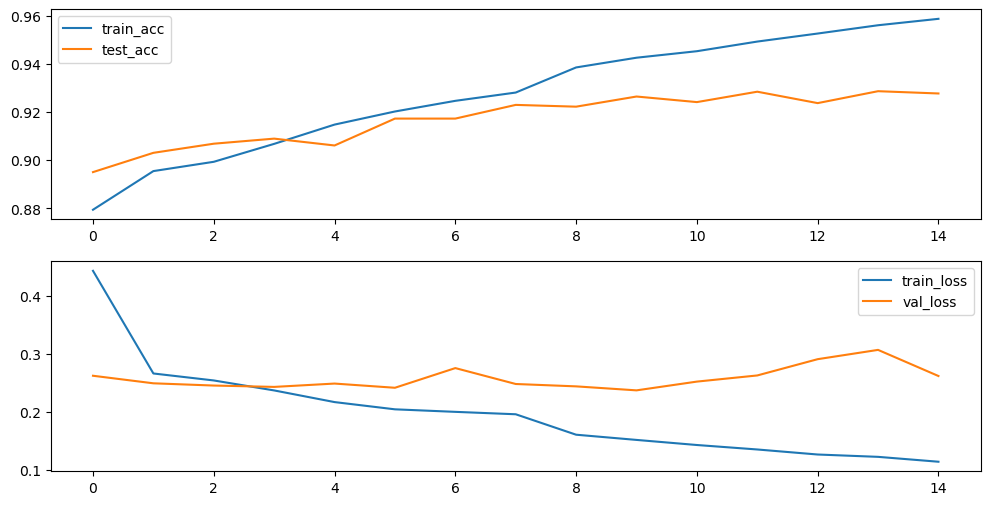

In [22]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

297/297 [==============================] - 133s 446ms/step


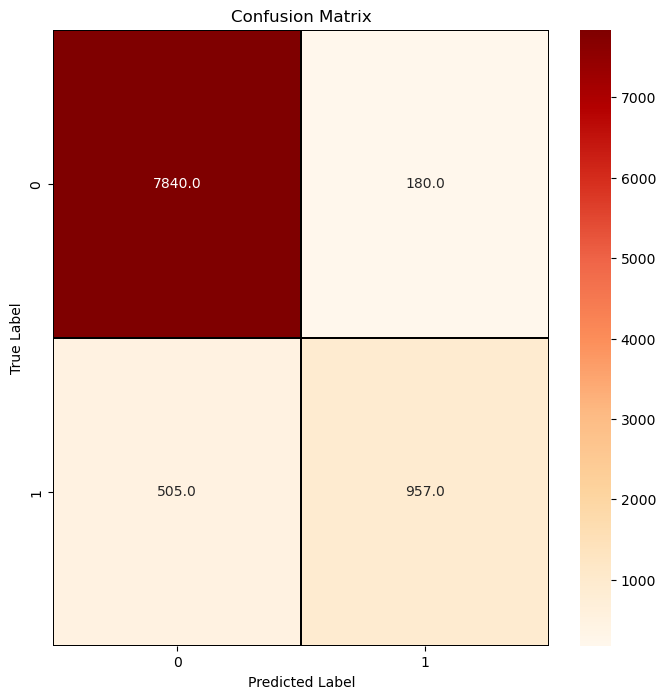

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8020
           1       0.84      0.65      0.74      1462

    accuracy                           0.93      9482
   macro avg       0.89      0.82      0.85      9482
weighted avg       0.92      0.93      0.92      9482

